Convolution with pseudorandom time-domain sequences for spread-spectrum communications
========

I've been thinking for a while
about a family of communication systems
using random bit sequences
that I thought might work.
I tried them in this notebook
and it seems like they do work well.

The fundamental intuition is that,
by convolving your message with a time-domain "spreading" signal,
you get a message that looks like white noise in the pure time domain,
or if despread with a different spreading signal.
That way, as with other forms of CDMA, many such messages can share a communications channel
without collisions;
each just raises the noise floor for the others.

This is similar to direct-sequence spread spectrum,
but in DSSS the signal is multiplied by the spreading sequence in the time domain,
resulting in a convolution in the frequency domain,
so clock synchronization is essential.
By contrast, here, *frequency* synchronization is essential,
but the phase can be recovered from the signal
without pre-existing synchronization.

As a result,
in this method,
this "spreading" signal doesn't actually broaden the spectrum at all,
just shift phases and attenuate certain frequencies.
(It doesn't look like white noise in the frequency domain,
just the time domain.)
To broaden the spectrum with time-domain techniques,
making it possible to recover information from interference,
we resort to zero-insertion, replicating the baseband signal
across the entire spectrum.

A second idea is that
nonlinear approximations of these white-noise bursts
can perhaps still be decoded usefully;
for example, rounding them off to one bit per sample,
or transmitting pulses during 99th-percentile peaks
while remaining silent the rest of the time,
or convolving with a sparse approximation of the original white-noise signal.
We should expect this to work because the despreading process
should transform the highly nonrandom quantization noise
into ordinary Gaussian noise,
which regular error correction codes can cope with.

So here are some explorations.

Summary of the most interesting results
--------

In one experiment, I represented a 2500-bit message
with 128 timeslots per bit,
each timeslot transmitting either zero, a unit positive pulse, or a unit negative pulse,
according to a 4096-bit spreading sequence,
with 99.4% of the slots being zero (so each pulse transmits about 1.2 bits),
and decoded it simply by convolving it with the (time-reversed) spreading sequence.
The bit error rate in the experiment is 0.8%,
which is pretty terrible for no noise.
However, I was optimistic about this, because,
to the demodulation process,
the intersymbol interference looks like noise that's 8dB above the signal
before despreading.
So it seemed to me that this level of robustness against ISI
probably meant it would work with white noise too.

In another experiment, I added white noise to that sparse signal,
and decoded it from 8dB below the noise floor with a 13–14% bit error rate (BER)
without ECC.

In a third, I added white noise to the dense signal it was derived from
(128 samples per bit)
and decoded the signal from 18dB below the noise floor
with a 7&ndash;8% BER.


In [1]:
%pylab inline
rcParams['figure.figsize'] = (12, 2)
rcParams['lines.linewidth'] = 0.5

Populating the interactive namespace from numpy and matplotlib


Here's a random bit sequence.

In [2]:
#random.random(64).round().astype(int)
rbs = array(
      [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1])
rbs

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1])

It has reasonably small autocorrelation at nonzero shifts, though an LFSR M-sequence would be better.

34

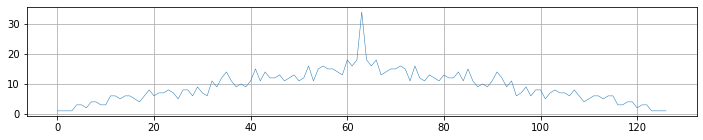

In [3]:
nca = convolve(rbs, rbs[::-1])
plot(nca)
grid(True)
nca.max()

I'm not sure how to compute the cyclic convolution, but maybe I don't actually need it for this purpose.

We get a flatter signal and a better noise margin if we represent the bits as $\pm 1$,
with something like a factor of 8 separation between signal and noise (18 dB),
which is the sort of SNR improvement you'd expect from averaging 64 samples.

(64,
 5.656854249492381,
 array([-1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1,
         1,  1, -1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1, -1,
        -1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1,  1, -1, -1, -1, -1,
         1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1, -1]))

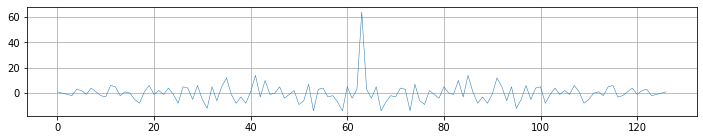

In [4]:
rns = 1 - 2 * rbs
ncn = convolve(rns, rns[::-1])
plot(ncn)
grid(True)
ncn.max(), (ncn[:ncn.argmax()]**2).mean()**.5, rns

Let's try encoding an actual signal with it.

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,

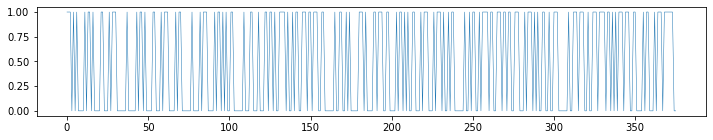

In [5]:
textb = 'What hath the Flying Spaghetti Monster wrought?'
bits = (right_shift.outer(array([ord(c) for c in textb]),
                          arange(8))).ravel() & 1
plot(bits)
bits

-0.21867881548974943

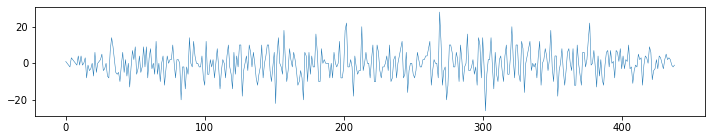

In [6]:
bc = convolve(1 - 2 * bits, rns)
plot(bc)
bc.mean()

So there we have a signal where each bit is smeared out over 64 samples,
from which perhaps we can recover an approximation of the original message
by correlating it with our random time-domain carrier?

CPU times: user 23.6 ms, sys: 3.8 ms, total: 27.4 ms
Wall time: 24 ms


0.7649402390438247

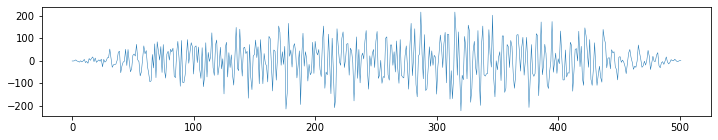

In [7]:
%%time
bcc = convolve(bc, rns[::-1])
plot(bcc)
bcc.mean()

It isn't obvious how well that represents the original bits; we can try correlating it with them.

(24624, 438)

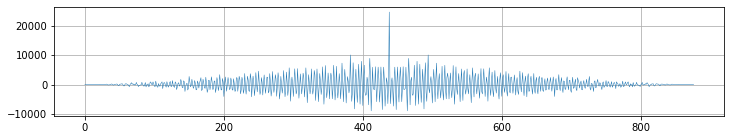

In [8]:
match = convolve(bcc, 1 - 2 * bits[::-1])
plot(match)
grid(True)
match.max(), match.argmax()

Well, there is a nice peak there in the middle, at offset 438,
with 2.4 times the amplitude of anything else.
What does that mean in terms of actual data recoverability?

In [9]:
len(match), len(bcc), len(bc), len(bits), len(rns)

(877, 502, 439, 376, 64)

In [10]:
376 + 64 - 1, 439 + 64 - 1, 502 + 376 - 1, 438 + 1 + 438

(439, 502, 877, 877)

So in theory our bits ought to be in `bcc` after 63 + 63 samples of partial overlaps?  No, just 63.

In [11]:
(bcc[63:63+len(bits)] * (1 - 2 * bits)).sum()

24624

If we try to recover the bits by thresholding `bcc`, how many of them come out right?

In [12]:
((bcc[63:63+len(bits)] < 0) == bits).mean()

0.8882978723404256

About 89% of the bits come out right.  That's not terrible
(if you have some ECC, or perhaps even erasure coding)
but not okay on its own.  Less than half the letters are correct:

In [13]:
def latin1dec(signal):
    bytes = len(signal)//8
    return ''.join(chr(n) for n in ((signal[:bytes*8] < 0).astype(int)
                               .reshape((bytes, 8))
                                * 2**arange(8)
                                ).sum(axis=1))

print(latin1dec(bcc[63:63+len(bits)]))
print(textb)

Wh`t"meVj&4hg¢F,yang"W°dgjg2te$OOfó´dr$w6oegjt?
What hath the Flying Spaghetti Monster wrought?


Using longer carrier sequences increases the error rate
----------

An interesting question is how this changes if the bit sequence length goes up.
If you convolve with a noise sequence that's $N$ times longer, the signal for a given bit
has $N$ times the amplitude, but it also contributes $N$ times as much noise energy to other bits.
But you might think that would mean
that the amplitude of noise goes up by $\sqrt N$, so you have improved
the signal to noise ratio by $\frac N{\sqrt N} = \sqrt N$,
or $N$ in power terms.
I thought this meant you'd actually win by a lot,
but it was rather late at night for me to figure out Gaussian quantiles with confidence.

Then I tried this experiment, which convinced me otherwise.

Let's try a 256-bit sequence, which ought to give us twice the SNR by amplitude
(and four times the SNR by power),
but to avoid getting unrealistically optimistic results,
let's use a message that's several times that length, like 256 *bytes* or so.

1.0

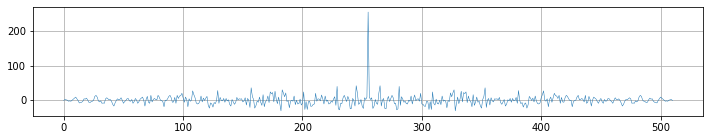

In [14]:
#random.random(256).round().astype(int)
rns2 = 1 - 2 * array(
      [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0])
plot(convolve(rns2, rns2[::-1]))
grid(True)
(rns2**2).mean()**.5

(314, 2512)

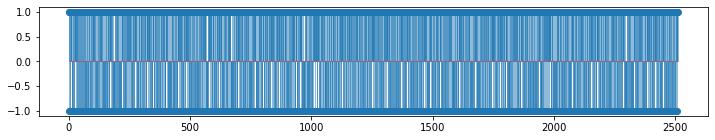

In [15]:
msg = """The licenses for most software and other practical works are designed
to take away your freedom to share and change the works.  By contrast,
the GNU General Public License is intended to guarantee your freedom to
share and change all versions of a program--to make sure it remains free
software for all its users.
"""
mbn = 1 - 2 * ((right_shift.outer(array([ord(c) for c in msg]),
                                  arange(8))).ravel() & 1)
def stem(*args, **kwargs):
    pyplot.stem(*args, use_line_collection=True, **kwargs)

stem(mbn)
len(msg), len(mbn)


We encode, as before, by convolving with our random bit sequence.

0.14311528731478135

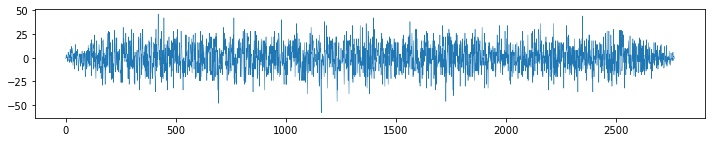

In [16]:
bc2 = convolve(mbn, rns2)
plot(bc2)
bc2.mean()

0.26207809397749837

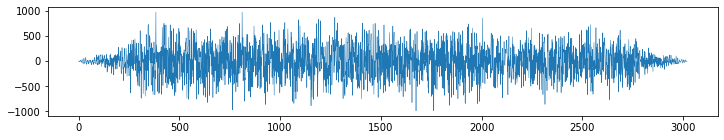

In [17]:
bcc2 = convolve(bc2, rns2[::-1])
plot(bcc2)
bcc2.mean()

In [18]:
((bcc2[255:255+len(mbn)] < 0) == (mbn < 0)).mean()

0.7742834394904459

So, contrary to my prediction, it seems like
spreading the bits over a larger time window like this
actually makes the error rate higher, not lower!
The effect of the original message is still quite visible, because all other shifts
have very close to the 50% expected correlation:

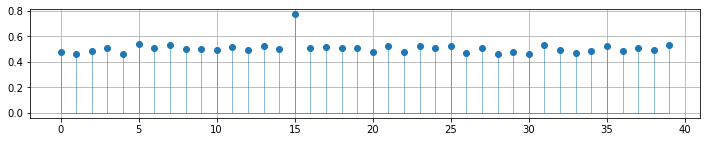

In [19]:
stem([((bcc2[n:n+len(mbn)] < 0) == (mbn < 0)).mean()
      for n in range(240, 280)])
grid(True)

Zero-insertion improves the error rate
----------

A simple thing to do to improve the situation is to insert zeroes into the convolution sequence.
This way, the bursts of noise
representing different bits
overlap less.

array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,
        0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  0.])

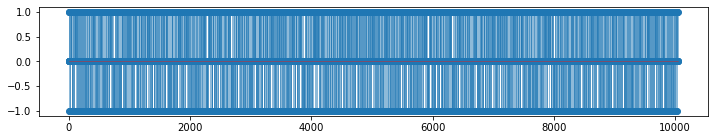

In [20]:
mbn4 = zeros(4 * len(mbn))
mbn4[::4] = mbn
stem(mbn4)
mbn4[:26]

0.038435407162962246

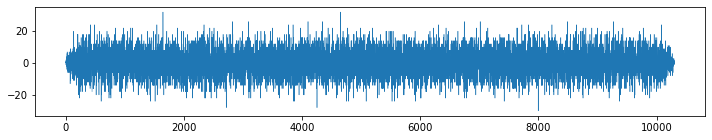

In [21]:
bc4 = convolve(mbn4, rns2)
plot(bc4)
bc4.mean()

So that's our encoded signal; let's try correlating it with our carrier noise burst
to see if we got anything plausible.

0.07501420723621897

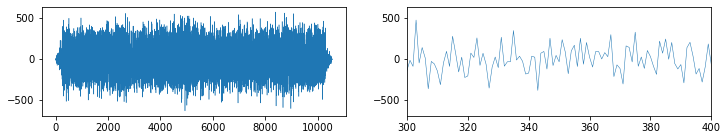

In [22]:
bcc4 = convolve(bc4, rns2[::-1])
subplot(121); plot(bcc4)
subplot(122); plot(bcc4); xlim(300, 400)
bcc4.mean()

That looks somewhat promising, because it looks like the amplitude tends to spike at powers of 4.

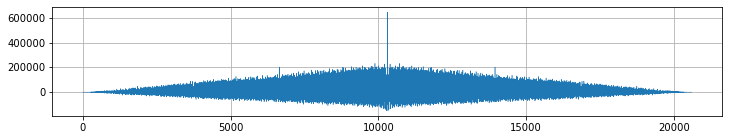

In [23]:
plot(convolve(bcc4, mbn4[::-1])); grid(True)

A factor of about 3 in amplitude between the correct shift and random incorrect shifts
is not super inspiring.  Let's see how that pays off in terms of bit error rate.

In [24]:
((bcc4[255:255+len(mbn)*4:4] < 0) == (mbn < 0)).mean()

0.9952229299363057

Oh holy shit, 0.48% bit error rate?  That's a lot better than I was expecting.
Let's motherfucking decode this motherfucker!

In [25]:
print(latin1dec(bcc4[255:255+len(mbn)*4:4]))
print(msg)

The licenses for most software and other prakTical works are designed
to taje away your freedom to share and change the works.` By contrast,
the GNU General Public License is intended to guarantee your freedom to
share and change all versions of a prograi--to m!je s5re iT rehains free
software f/r all its users.

The licenses for most software and other practical works are designed
to take away your freedom to share and change the works.  By contrast,
the GNU General Public License is intended to guarantee your freedom to
share and change all versions of a program--to make sure it remains free
software for all its users.



Truncation to one bit per sample makes the error rate only a few times higher
-----------

Let's try truncating our encoded `bc4` to one bit per sample.

-0.10511501504416189

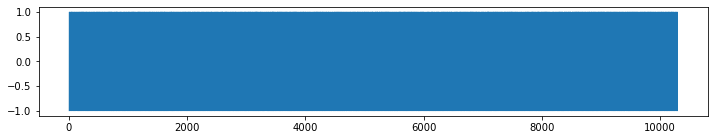

In [26]:
bc4t = where(bc4 > 0, 1, -1)
plot(bc4t)
bc4t.mean()

That seems to be about 79% correlated with the original signal, so maybe we haven't lost much:

In [27]:
(bc4t * bc4).mean() / (bc4t**2).mean()**.5 / (bc4**2).mean()**.5

0.7888988086123153

Indeed, this plot barely looks worse than before:

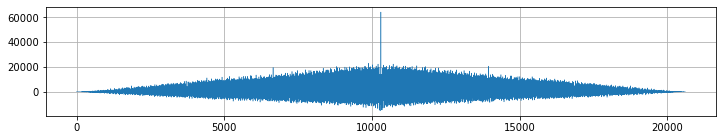

In [28]:
bcc4t = convolve(bc4t, rns2[::-1])
plot(convolve(bcc4t, mbn4[::-1])); grid(True)

The bit error rate is 3.4%, several times worse but by no means absurd:

In [29]:
print(latin1dec(bcc4t[255:255+len(mbn)*4:4]))
((bcc4t[255:255+len(mbn)*4:4] < 0) == (mbn < 0)).mean()

The licenw%s fgr mort softwire(and other0prajTical wkrks(are designee
to)t!je a7ay yotz freeejm to óHar% and chance(the wkrks.` By contract¬
5ha`ÇNU Fene2al!Public*Licejsm is Intenddd"to fUéRantee youz freeeom to
shabe and change(all versIons mf*a rrogrii--to makE¨s5re kT rehqinw fbme
softwire(f/r"all8its"users.



0.9661624203821656

What it looks like in the frequency domain
--------

Our operation of convolving with a time-domain kernel to spread out each bit in time
amounts to applying a FIR filter, which will tend to make the signal less uniform in the frequency domain.

Our original signal consists of a bunch of 8-bit ASCII bytes, so it has a strong component
at one eighth the sample rate, *i.e.*, one fourth of the Nyquist frequency.
And that has three other strong harmonics.
Everything else is about 15 dB down from that.

Here I'm arbitrarily choosing $100\,000$ samples as the relevant period.

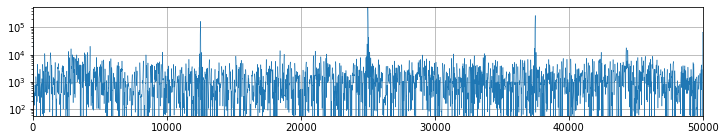

In [30]:
def freqplot(signal, npoints=100_000):
    padded = zeros(npoints)
    padded[:len(signal)] = signal
    power = abs(fft.fft(padded)**2)
    plot(power)
    gca().set_yscale('log')
    ylim(power.max() / 1e4, power.max())
    xlim(0, len(padded)/2)
    grid(True)
    
freqplot(mbn)

The convolved signal looks significantly less white, but also lacks some of those peaks:

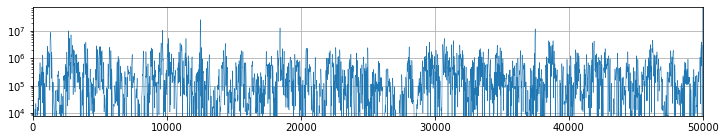

In [31]:
freqplot(bc2)

Like, it looks extremely nonwhite, with a very substantial fraction of its energy in a few peaks.
If you were listening to this signal, you would clearly hear that baud-rate tone.

(0, 40000000.0)

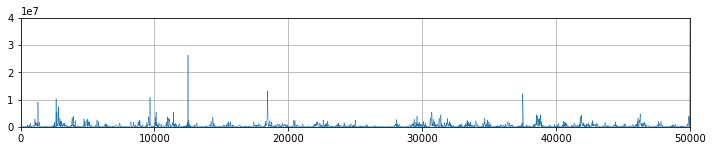

In [32]:
freqplot(bc2); gca().set_yscale('linear'); ylim(0, .4e8)

That's maybe because our spreading sequence has a bunch of strong nulls in its spectrum, and some of them
happen to coincide with our original signal's harmonics.  Because it's so short
(only 256 bits) it necessarily has a pretty bumpy spectrum, sort of interpolating
between its response at the harmonics of its fundamental.

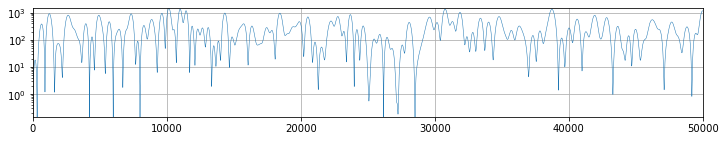

In [33]:
freqplot(rns2)

You can kind of see actually how they fit together visually.

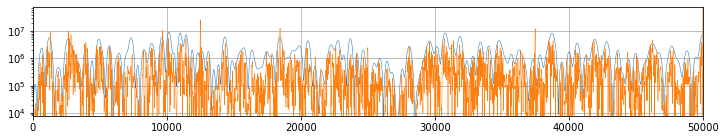

In [34]:
freqplot(rns2 * 80); freqplot(bc2)

The zero-inserted version of the signal has the same spectrum, but repeated four times.
The four strong harmonics we saw above are squinched down into 16 copies of the four,
repeated backwards and forwards.
Otherwise it still looks pretty white.

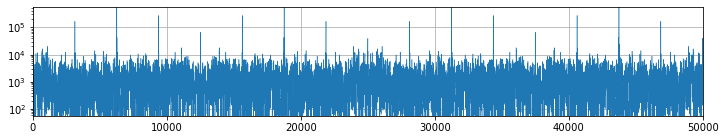

In [35]:
freqplot(mbn4)

The convolved signal now has some copies of all those peaks survive, because they're no longer all colliding
with nulls.  It still looks significantly less white because of how it's molded into the spectrum of the kernel.

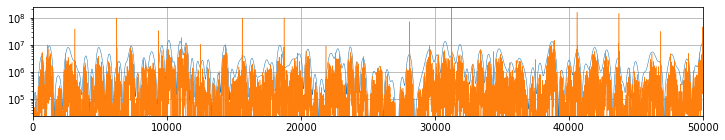

In [36]:
freqplot(rns2 * 100); freqplot(bc4)

Truncating down to one bit per sample does look, in the frequency domain, like adding a bunch of white noise.
This makes the signal noticeably whiter, though it's still obviously not a random signal.
On a simple sinusoid, that kind of clipping or saturation tends to introduce certain harmonics,
but I don't think that gives you a good picture of what it does to a white-noise signal.

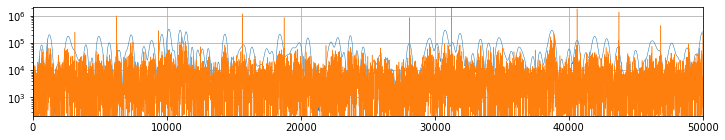

In [37]:
freqplot(rns2 * 15); freqplot(bc4t)

We should be able to subtract out the truncation "noise" and see what it looks like.
I think this requires us to normalize for power, because there's about 20 dB
of power difference between the truncated and non-truncated signals.
This does have some frequencies that are 10 dB or more above the crowd,
and they are specifically frequencies where the original signal was strong:

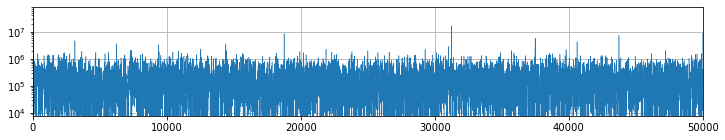

In [38]:
power_ratio = sum(bc4t**2)/sum(bc4**2)
freqplot(bc4t / power_ratio**.5 - bc4)

Transmitting just the highest-energy samples
----

An interesting question is how much of the signal energy is concentrated in a few high-energy samples.
They should have a Gaussian distribution, which isn't fat-tailed, but it does still have infinite tails.
Eyeballing, it looks like we could transmit 50% of the sample energy
by transmitting the most energetic 10% of the samples:

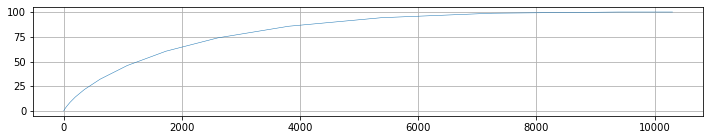

In [39]:
energypdf = sorted(bc4**2, reverse=True)
energycdf = cumsum(energypdf)
plot(energycdf * 100 / energycdf.max()); grid(True)

And by transmitting the most energetic 2% of the samples, we could transmit 14.7% of the signal energy,
and with 5%, 28%:

In [40]:
energycdf[(len(energycdf) * array([.01, .02, .05, .1, .2, .5, .99]))
          .round().astype(int)] / energycdf.max()

array([0.08573391, 0.1468743 , 0.28300789, 0.44725697, 0.65549286,
       0.93124799, 1.        ])

We surely don't have enough zero-insertion in the current signal for this to give us a decodable result,
but let's see how bad it is anyway.

In [41]:
energy_threshold = energypdf[(len(energycdf) * array(.05))
                             .round().astype(int)]
energy_threshold

256.0

We've selected the 5.9% of the samples containing 31.7% of the energy:

(0.31745737124755613, 0.058526642725419784)

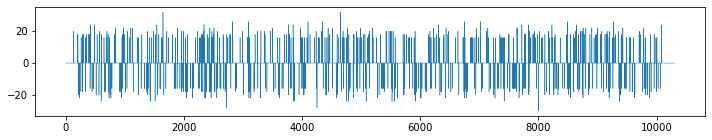

In [42]:
rala = where(bc4**2 >= energy_threshold, bc4, 0)
plot(rala)
sum(rala**2) / sum(bc4**2), (rala != 0).mean()

In the frequency domain it looks like a noisier, attenuated version of the original signal:

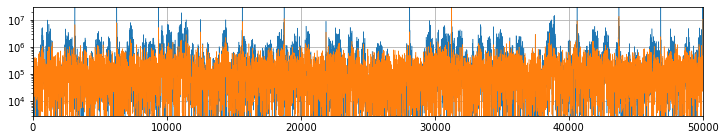

In [43]:
freqplot(bc4); freqplot(rala)

Let's see what we can decode.

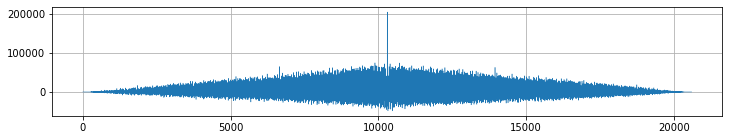

In [44]:
ralac = convolve(rala, rns2[::-1])
plot(convolve(ralac, mbn4[::-1])); grid(True)

That looks pretty similar to before, just at a lower power level?  And it looks like the bit error rate is 11.4%:

In [45]:
print(latin1dec(ralac[255:255+len(mbn)*4:4]))
((ralac[255:255+len(mbn)*4:4] < 0) == (mbn < 0)).mean()

Tje`lHke~S-{!fMz mf;|(smftw reqhd Ujes pb!c4iCaí W/uks are(¤ òig.id
t/ v%iõ qWiy 9nô êreædkm tF(q cRe"Ahdsha*&%$the WorcS.1 By(c-nt²!ãV$ZÔhe CJU G%nt2á|$Uâtib!L`ce.sÔ aV"yì en$ad Tf&g4br!jtam Yfp êreddkm"vfq(cSdbAhdóxafoe(cl$!V%zSiOls*gf i¤qÒKgr%m-­v' m je s%2e iU råheIl#4frgd
s-ftg se"flr(ann$a4s`use2*;


0.8857484076433121

In some sense it's pretty crazy that we could throw away 94% of our signal in the time domain
and still decode 88.6% of the bits correctly.
On the other hand, the sparse signal still contains a lot more entropy than the original signal;
it's been zero-inserted by a factor of 4×,
so there are four samples for each original bit,
and each of those samples contains a lot more than one bit
of information.
To me,
one potentially interesting thing about this kind of sparse time-domain signal
is that it could allow a radio transmitter to operate with a low duty cycle;
by being turned off 94% of the time, it uses almost 94% less power,
because the majority of the power used by high-precision analog electronics
is passive power, not transmitted out onto the airwaves.
Also, as shown by the one-bit-truncation results earlier,
even gross nonlinearities in the voltage domain can be compensated for
by high precision in the time domain,
and grossly nonlinear transmitters can be much simpler and more efficient.
But, in reality,
my interest is in signals much sparser than this.

Another use of such sparse signals,
though probably not encoded in this particular way,
is for deniable encryption:
many blocks of data
can be encoded in the same (much larger) disk block
without knowledge of one another
if each new data block recorded
only sets some of the bits in the disk block.

The numbers all go to 11, look, right across the board, 11, 11, 11
---------------

Let's see about using an LFSR M-sequence of, say, 4095 bits,
and using $128\times$ zero-insertion,
and taking the most powerful 0.5% of samples,
and rounding them to $\pm 1$.

There's a handy [table of generator polynomials in Wikipedia][53], which for period 4095 has $x^{12}+x^{11}+x^{10}+x^4+1$, 0xe08.

[53]: https://en.wikipedia.org/wiki/Linear-feedback_shift_register#Example_polynomials_for_maximal_LFSRs

(4096,)

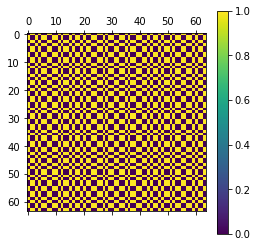

In [46]:
poly12 = 0xe08
mask12 = 0xfff
# Precompute parity (popcount mod 2) of all 12-bit integers.
par12 = zeros(4096, dtype=int)
for i in range(2**12):
    p = b = i
    while p:
        p >>= 1
        b ^= p
    par12[i] = b & 1

matshow(par12.reshape((64, 64)))
colorbar()
par12.shape

Let's generate our M-sequence up to length 8192 and verify visually that it does repeat,
but only two complete repetitions (to ensure we aren't accidentally computing a non-maximal LFSR,
or something that isn't an LFSR at all.)

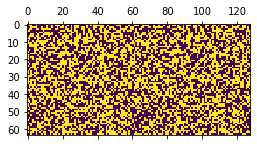

In [47]:
lfsr12 = zeros(8192)
register_state = 1
for i in range(len(lfsr12)):
    lfsr12[i] = register_state & 1
    register_state = ((register_state << 1)
                      & mask12) | par12[register_state
                                        & poly12]
    
matshow(lfsr12.reshape((128, 64)).T)
lfsr12 = lfsr12[:4095]

Now let's look at its autocorrelation function.

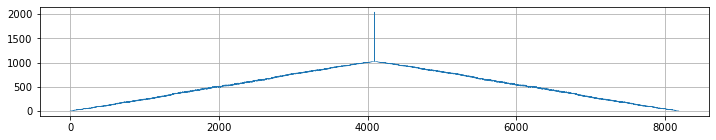

In [48]:
plot(convolve(lfsr12, lfsr12[::-1]))
grid(True)

That's motherfucking beautiful.  But let's get rid of that big mound.

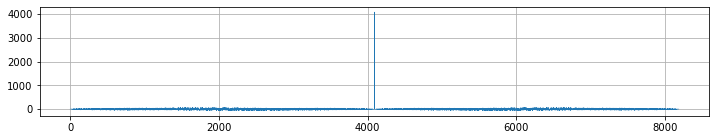

In [49]:
lfsrn = 1 - 2 * lfsr12
plot(convolve(lfsrn, lfsrn[::-1]))
grid(True)

That's even better.  What does it look like in the frequency domain?

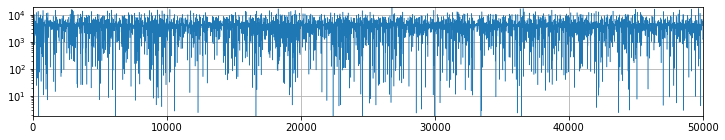

In [50]:
freqplot(lfsrn)

That looks pretty flat, a lot more than the shorter actually-random sequences above.

Now let's generate our $128\times$ zero-inserted message bits.

0.0006157941878980891

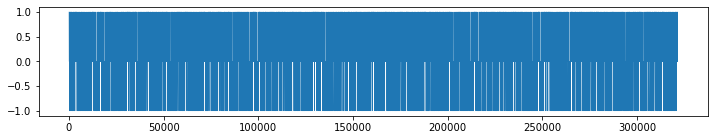

In [51]:
m128 = zeros(len(mbn) * 128)
m128[::128] = mbn
plot(m128)
m128.mean()

And now here's our encoded message.

In [52]:
%%time
s128 = convolve(m128, lfsrn)
s128.mean()

CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.15 s


-0.000608052083653226

(-22.0, 26.0)

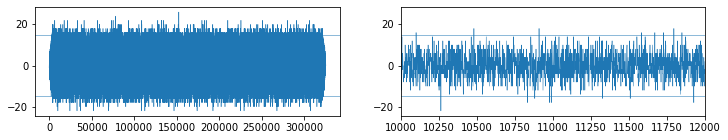

In [53]:
def dlimits(n):
    axhline(n)
    axhline(-n)

subplot(121); plot(s128); dlimits(15)
subplot(122); plot(s128); xlim(10000, 12000); dlimits(15)
s128.min(), s128.max()

It's a shame that matplotlib plot() does so poorly with so many data points.
Out of $\frac{4095}{128} \approx 32$ values that could potentially be in phase
at a given sample, it's all in $\pm 22$ except for one value that made it to 26.
But there are lots and lots of 18 values.  Also apparently virtually all the values are even,
I guess because virtually all the samples are overlapped by the impulse responses
of 32 samples, each pair of which is either in phase (+2 or -2) or out of phase (+0).

Let's look at the distribution to see where we have to do the haircut to get $\pm 0.5\%$.

(array([-22., -21., -20., -19., -18., -17., -16., -15., -14., -13., -12.,
        -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,
          0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.]),
 49,
 48)

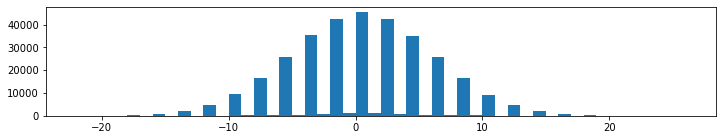

In [54]:
weights, bins, _ = hist(s128, 26+22)
bins, len(bins), len(weights)

Okay, so how about a brute-force approach?  We want the most extreme 0.5% of the points,
not the extreme points that account for 0.5% of the energy.

array([1.000e+00, 8.606e-01, 8.525e-01, 5.915e-01, 5.862e-01, 3.700e-01,
       3.667e-01, 2.080e-01, 2.061e-01, 1.051e-01, 1.042e-01, 4.740e-02,
       4.700e-02, 1.820e-02, 1.800e-02, 6.200e-03, 6.200e-03, 1.800e-03,
       1.800e-03, 4.000e-04, 4.000e-04, 1.000e-04, 1.000e-04, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00])

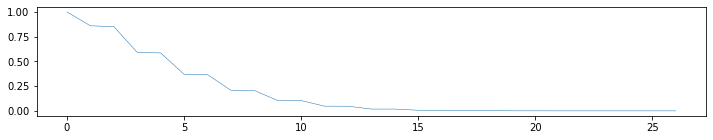

In [55]:
invquantiles = array([(s128**2 >= i**2).mean() 
                      for i in range(27)])
plot(invquantiles)
invquantiles.round(4)

It's a little hard to read but it looks like 15 is the cutoff for 0.62% of the points, which is the closest
we get to 0.5%:

In [56]:
100 * invquantiles[15]

0.6240211282744218

As it turns out,
they contain 5.7% of the energy of the original signal:

(0.05692271068084431, 0.6240211282744218)

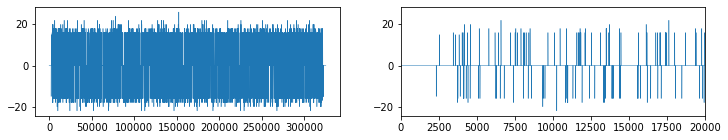

In [57]:
s128r = where(abs(s128) >= 15, s128, 0)
subplot(121); plot(s128r)
subplot(122); plot(s128r); xlim(0, 20000)
(s128r**2).sum() / (s128**2).sum(), (s128r != 0).mean() * 100

(10000, 12000)

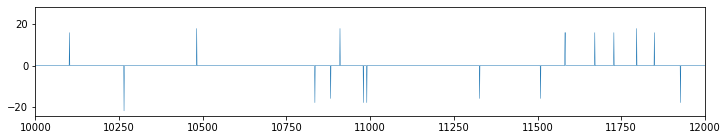

In [58]:
plot(s128r); xlim(10000, 12000)

Most of the values are actually literally 16; only a third of them are 17 or more.
If we clip to just the values $\pm 16$ the energy should be only slightly reduced:

0.0515981590223774

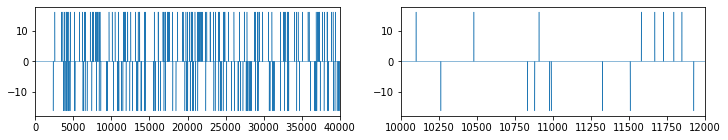

In [59]:
s128c = where(s128r > 0, 16, where(s128r < 0, -16, 0))
subplot(121); plot(s128c); xlim(0, 40000)
subplot(122); plot(s128c); xlim(10000, 12000)
(s128c**2).sum() / (s128**2).sum()

So this represents a transmitter with a duty cycle of 0.6% transmitting a sequence of positive and negative pulses,
all of the same amplitude.  Let's see what we get if we try to decode it in the same way we were doing before.

In [60]:
%%time
s128cc = convolve(s128c, lfsrn[::-1])

CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.17 s


In [61]:
%%time
s128ccm = convolve(s128cc, m128[::-1])

CPU times: user 3min 3s, sys: 22.1 s, total: 3min 25s
Wall time: 54.4 s


That's a bit slow, but SciPy ought to come to the rescue with Fourier correlation.
In this case it's three orders of magnitude faster.
For LFSR M-sequences in particular there's an algorithm due to [Cohn and Lempel in 01977][5353]
using the Fast Hadamard Transform
which is about another order of magnitude faster still.

[5353]: https://doi.org/10.1109/tit.1977.1055666

In [62]:
import scipy.signal

In [63]:
%%time
s128ccm2 = scipy.signal.fftconvolve(s128cc, m128[::-1])

CPU times: user 119 ms, sys: 842 µs, total: 119 ms
Wall time: 118 ms


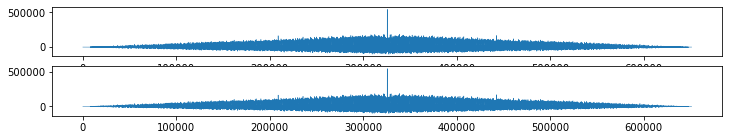

In [64]:
subplot(211); plot(s128ccm)
subplot(212); plot(s128ccm2)
None

The results are identical except for rounding errors of the order $10^{-16}$ times the data values.

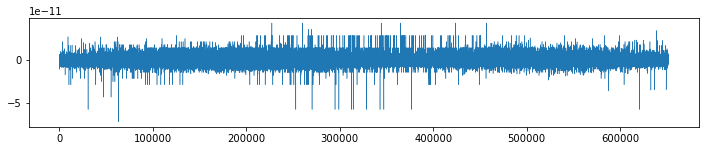

In [65]:
_ = plot(s128ccm - s128ccm2)

Anyway, so we have a nice sharp peak in the middle, so we probably have a significant
impulse-like correlation with our original signal.
Can we decode bits?

In [66]:
print(latin1dec(s128cc[4094:4094+len(mbn)*128:128]))
((s128cc[4094:4094+len(mbn)*128:128] < 0) == (mbn < 0)).mean()

The licenses for most software and other practical works are designed
to take away your freedom to share and change the works.  By contrasT,
the GNU Ge~eral Public License is intended to guarantee your freedom to
share and change all versions of a program--to make sure it remains free
software for all its users.



0.9992038216560509

It looks like we were able to decode the entire message 99.9% perfectly, with only two bit errors.
We wouldn't even need that whole 0.6% of the signal with a little light ECC.

How many pulses are we transmitting per bit?  It seems like it should be less than one, since I did 128×
zero-insertion and then winnowed down to 0.6%.

In [67]:
(s128c != 0).sum(), (mbn != 0).sum(), len(msg) * 8

(2032, 2512, 2512)

Yes, it's transmitting about about 1.2 bits per pulse.  That's not terribly astounding, since we're assuming
timing precision of about one part in 1.2 million and exploiting it to the hilt, and additionally
have both positive and negative pulses, but it's good to see that
we're not utterly wasting that transmission capacity.
Without any noise, in theory,
you should be able to communicate a bit over 8 bits per pulse
under such circumstances.

(One part in 1.2 million might be pushing the limits of the practical
for time-domain signals, though [OCXOs and presumably MCXOs can manage][33]
one part in a trillion over a few seconds.)

[33]: https://en.wikipedia.org/wiki/Crystal_oven#Comparison_with_other_frequency_standards

What does this look like in the frequency domain?

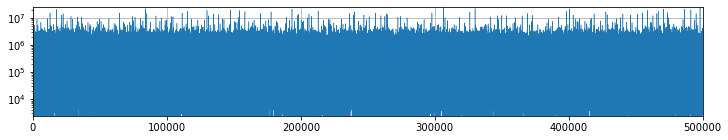

In [68]:
freqplot(s128c, npoints=10**6)

Reassuringly, it looks a lot more like white noise than our previous signals.
Let's zoom in on just the first fifty thousand frequencies; it still looks almost like white noise,
though I think I might see a little structure.

(0, 50000)

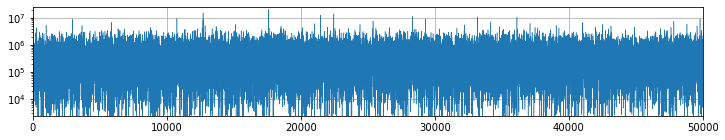

In [69]:
freqplot(s128c, npoints=10**6); xlim(0, 50000)

We can see that the signal we get at the proper alignment is significantly larger than the signals we see at other offsets.

126

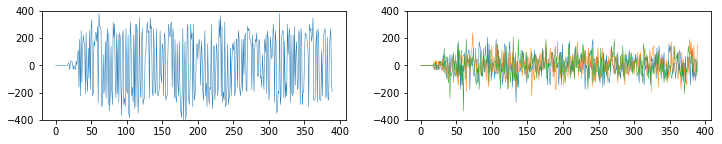

In [70]:
subplot(121); plot(s128cc[126:50000:128]); ylim(-400, 400)

subplot(122)
plot(s128cc[127:50000:128])
plot(s128cc[128:50000:128])
plot(s128cc[129:50000:128])
ylim(-400, 400)

4094 % 128

Moreover, it's quite substantially bimodal, with values clustering around
1 bits and 0 bits, plus the noise.  The clustering would be a lot tighter
if the signal weren't so sparse.

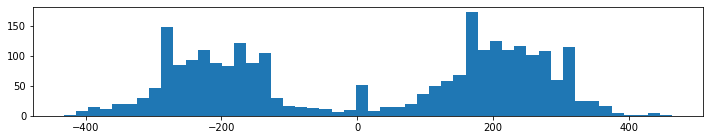

In [71]:
_ = hist(s128cc[126::128], 50)

Other offsets do not have this bimodality.

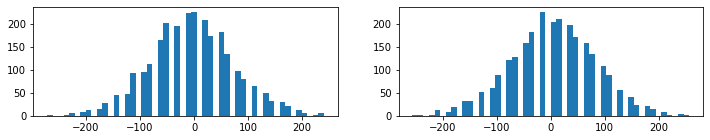

In [72]:
subplot(121); _ = hist(s128cc[127::128], 50)
subplot(122); _ = hist(s128cc[128::128], 50)

Can this signal survive any noise?
------------

Let's try adding some noise a bit less intense than the signal,
in the sense that the noise's overall power is a bit less.

I'm not sure an LFSR is actually random enough here,
though an LFSR would be reproducible here
despite changes in Numpy and Python versions.
I'm just using the PCG64 generator, which says in its docstring:

> **Compatibility Guarantee**
> 
> ``PCG64`` makes a guarantee that a fixed seed will always produce
> the same random integer stream.

In [73]:
# for some minimal semblance of reproducibility
rng = random.Generator(random.PCG64(1))
rng.integers(2**32)  # should be 2032329983

0

Originally I did this part of the notebook with uniform random noise generated like this, which has mean
$\frac 12$.

In [89]:
((rng.random(len(s128c))-.5)**2).mean()**.5, (1/12)**.5

(0.2889687354230964, 0.28867513459481287)

But then I decided that was wrong, because the dc bias of the noise
makes it appear harder to filter linearly than it really is,
and also there is some stuff later about nonlinear filtering for which
the uniform distribution is also an unfair advantage.
So now I'm redoing it with additive white Gaussian noise,
but I want the AWGN to have the same power, which is apparently $\sqrt\frac 1{12}$.

0.28886120863303844

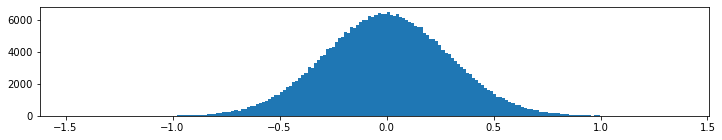

In [92]:
noise = rng.normal(scale=(1/12)**.5, size=len(s128c))
hist(noise, 200)
(noise**2).mean()**.5

In [93]:
# previously: noise = rng.random(len(s128c))
def rms(signal):
    return (signal**2).mean()**.5

noisy = noise + s128c

rms(noise), rms(s128c), rms(noisy)

(0.28886120863303844, 1.2639201273745584, 1.29575332220201)

(10000, 12000)

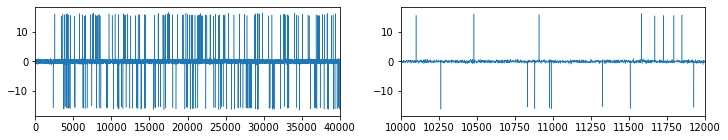

In [94]:
subplot(121); plot(noisy); xlim(0, 40000)
subplot(122); plot(noisy); xlim(10000, 12000)

That's sort of stupid because if you were really receiving a signal that looked like that you would probably just
drop the samples of low absolute value, a very simple kind of nonlinear filtering.  Still, let's see what we get.

In [95]:
%%time
ndc = scipy.signal.convolve(noisy, lfsrn[::-1])
len(ndc), len(s128cc)

CPU times: user 54.8 ms, sys: 0 ns, total: 54.8 ms
Wall time: 52.7 ms


(329724, 329724)

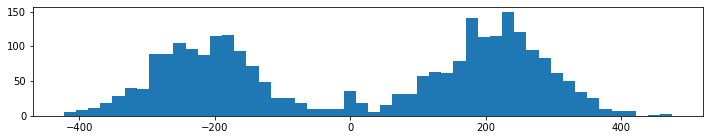

In [96]:
_ = hist(ndc[126::128], 50)

To the eye 
it looks exactly as bimodal as before, so apparently we can tolerate a lot more noise than that!

In [97]:
# 7 was arrived at by fiddling around until the proper alignment.
print(latin1dec(ndc[126+128*7::128]))

V#6The licenses for most software and other practical works are designed
to take away your freedom to share and change the works.  By contrasT,
the GNU Ge~eral Public License is intend%d to guaranteE your freedom to
share and c(ange all versions of a program--to make sure it remains free
software for all its users.
bG


### We can recover this sparse signal from 13dB below the noise floor with a 13–14% BER ###

If we add enough noise, the bit error rate gets high.

V«2×Ie <mcElses F'{ íïc× softsu2e !}m gtht` póBgticaü0÷Gr*ó c2e"dewi§nedto0ôà+@0awa9 yo3r rremh%,tm sèarE+bld@c(ángm vyfp.bn1. "By)óoî|rm3ä$
txa GN] zer|0Tu#ìik Lkò5nse(is"itmo5j9toheUijanvQD {ap feu$Mo!To"rhir` ámf"c(élce amq&r$vqkons%n2c ðãk§òam</|w e"kw&Suze0K| `Em6
nq g&eesn#twa`mgor c*l(ûtv 5Û-2óþbG
CPU times: user 144 ms, sys: 559 µs, total: 145 ms
Wall time: 142 ms


(3.1499193213949703, 1.2639201273745584)

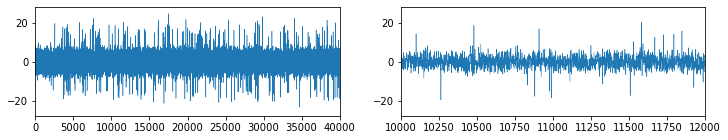

In [98]:
%%time
noise_amplitude = 10
noisier = noise*noise_amplitude + s128c
print(latin1dec(scipy.signal.convolve(noisier,
                                      lfsrn[::-1])[126+128*7::128]))
subplot(121); plot(noisier); xlim(0, 40000)
subplot(122); plot(noisier); xlim(10000, 12000)
rms(noisier), rms(s128c)

We've got about a 13% bit error rate here (13% and 14% on previous runs using the uniform noise):

In [100]:
((scipy.signal.convolve(noisier,
                        lfsrn[::-1])[4094:4094+len(mbn)*128:128]
  < 0) 
 == (mbn < 0)).mean()

0.8726114649681529

But our signal power is about 8 dB below the (additive, white, Gaussian)
noise at this point:

In [101]:
log10(rms(noisier)**2 / rms(s128c)**2)

0.7931596010697334

I think that validates the approach: this purely linear time-domain despreading
is able to recover 86% of the bits
without ECC
despite noise that's nearly than an order of magnitude higher in power.
This suggests that if we take the non-sparse signal we're processing 0.6% of here,
we'll be able to do a similar feat at an even higher noise power level.

With the sparse signal we have, as I said, a nonlinear alternative available:

In [110]:
print(latin1dec(scipy.signal.convolve(where(noisier**2 > 100, noisier, 0),
                                      lfsrn[::-1])[126+128*7::128]))

/$The licenses for most software and other practical works Are designed
to take away your freedom to share and change the works.  By contrast,
the GNU General Public License is intended to guarantee your freedom to
share and change all versions of a program--to make sure it remains free
software for all its users.
¨UW


Since our signal is so impulsive, and an impulse's spectrum is flat,
most of its energy is at high frequencies, logarithmically speaking.
So even in the presence of $1/f$ noise or something,
I think we could do that same filtering
to its first differences.

### Recovering the non-sparsified signal from 18dB below the noise floor with about 7&ndash;8% BER ###

In a more realistic test, using the non-sparse signal, we add noise that's 18 dB louder than the signal:

V«Vie ,mcElses F/r íoc× software!!le gtht` pó@cticaì wor*ó cre"$ewigne`
to0ô`+d away ymqr vremhm tm share!and cháNgm tid0work1. "By aoîxre3ä,
t(a GNU E~er!l Pu"ìik Liâ5nst is"iNtmod%` tohgUiz`nvee {.ap f2eq$Mm To"rhare áof chélge amí"~%zqkons 'f a prkçram-/| m`kg$Suzm ht pEm#
nq grde+snftgabmgor cll(ïts 5Ûmrs.
bG


1.7900791242617733

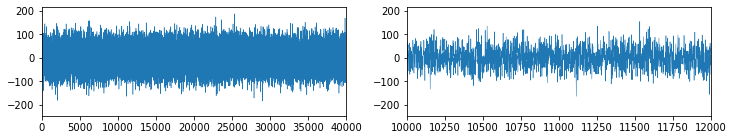

In [112]:
ens = s128 + 150 * noise  # even noisier still
print(latin1dec(scipy.signal.convolve(ens, lfsrn[::-1])[126+128*7::128]))
subplot(121); plot(ens); xlim(0, 40000)
subplot(122); plot(ens); xlim(10000, 12000)
log10(rms(ens)**2 / rms(s128)**2)

That's a bit error rate of only 7.1% (7.3%, 7.6%, and 8.4% on previous runs
with different, uniform random number sequences).

In [114]:
((scipy.signal.convolve(ens,
                        lfsrn[::-1])[4094:4094+len(mbn)*128:128]
  < 0)
 == (mbn < 0)
).mean()

0.9295382165605095